forked from main iowa_redistricting on march 28

manually implementing algorithm described in Chen and Rodden (2013)

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 


import math         ##for math.sqrt
import random       #for random selection of district to start with

# Prepping the census and geopandas dataframes

## Importing data

In [3]:
census_df=pd.read_csv('census.csv')
census_df['COUNTYFP10']=census_df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')
census_df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [4]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp').sort_values('NAME10',ignore_index=True)
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3996,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157..."
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,2185,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158..."
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,6934,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500..."
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,6245,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812..."
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,3457,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688..."


In [5]:
## Merging ONLY 2020 population #s from census df into shapefile_iowa
shapefile_iowa = shapefile_iowa.merge(census_df[['COUNTYFP10','population']], on='COUNTYFP10').copy()

#(otherwise this merge is only done for the map point later)

In [6]:
county_populations = np.array(census_df['population'])
state_population = sum(county_populations)
n_counties = 99
n_districts = 4
top_fifth_percentile=int(np.percentile(census_df['population'],95))

## Projecting shapefile to UTM 15N

In [7]:
#First, show the current coordinate reference system
shapefile_iowa.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [8]:
#Then project the shapefiles to UTM 15N
shapef_ia_proj = shapefile_iowa.to_crs(epsg=26915)

shapef_ia_proj.crs
# new_districts_shapefile_projected.crs

<Projected CRS: EPSG:26915>
Name: NAD83 / UTM zone 15N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 96°W to 90°W and NAD83 by country
- bounds: (-96.0, 25.61, -90.0, 84.0)
Coordinate Operation:
- name: UTM zone 15N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [9]:
shapef_ia_proj.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry,population
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((386139.673 4557123.147, 385899.972 4...",7496
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,1028,1108,49,2106,565,1395,146,3,"POLYGON ((347722.464 4557927.937, 347913.212 4...",3704
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((621990.182 4817526.586, 622024.806 4...",14061
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((491767.058 4517888.762, 491767.214 4...",12317
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((325801.578 4617291.999, 325803.323 4...",5674


In [10]:
shapef_ia_proj['geometry'].iloc[0].distance(shapef_ia_proj['geometry'].iloc[1])
# adair-to-adams distance is 0, so shortest distance, not centroid-to-centroid

0.0

## Merging pd and gpd dataframes and creating population heat map

In [14]:
shapefile_iowa.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'population'],
      dtype='object')

In [16]:
census_df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


In [21]:
# old version
# map_population_by_county_data = shapefile_iowa.merge(census_df, on='COUNTYFP10')


## Merging ONLY lat/long + county id from census df into shapefile_iowa (since population is already there)
map_population_by_county_data = shapefile_iowa.merge(census_df[['COUNTYFP10','latitude','longitude','county_id']], on='COUNTYFP10').copy()



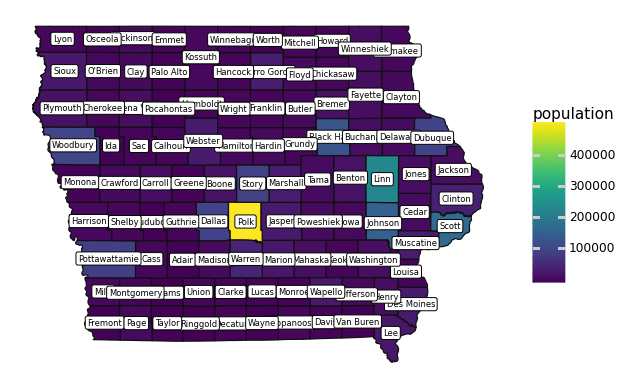

<ggplot: (8790902652055)>

In [22]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

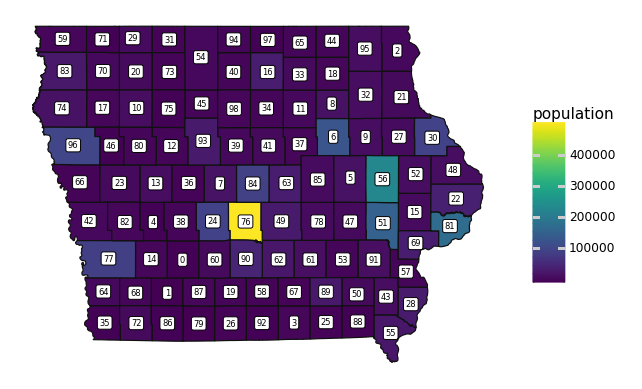

<ggplot: (8790902467416)>

In [23]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

# Creating the adjacency matrix for Iowa counties

In [ ]:
##########original version keeping here temporarily: superceded by function later

# # full statewide adjacency matrix (first boolean, then casting as int)
# #   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
# #   also should do this operation after any sorting of the original shapefile

# ia_adjac_matrix = pd.DataFrame()

# for j in range(n_counties):
#     ia_adjac_matrix[j] = shapefile_iowa.intersects(shapefile_iowa.iloc[[j]].unary_union)
# ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
# ia_adjac_matrix = ia_adjac_matrix.astype(int)

# ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



# Creating distance matrix for Iowa counties

In [24]:
# adding/fixing columns with (projected) centroid locations 
shapef_ia_proj['xcentr_lon'] = shapef_ia_proj.centroid.x
shapef_ia_proj['ycentr_lat'] = shapef_ia_proj.centroid.y
#shapef_ia_proj.info()
# shapef_ia_proj['xcentr_lon'].iloc[1]

In [25]:
shapef_ia_proj.columns

Index(['STATEFP10', 'COUNTYFP10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'ALAND10',
       'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'TOTPOP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'HISP', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'N_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP', 'TOTVOT00', 'PRES00D', 'PRES00R',
       'PRES00G', 'PRES00OTH', 'TOTVOT04', 'PRES04D', 'PRES04R', 'PRES04OTH',
       'TOTVOT08', 'PRES08D', 'PRES08R', 'PRES08OTH', 'TOTVOT12', 'PRES12D',
       'PRES12R', 'PRES12OTH', 'TOTVOT16', 'PRES16D', 'PRES16R', 'PRES16OTH',
       'CD', 'geometry', 'population', 'xcentr_lon', 'ycentr_lat'],
      dtype='object')

In [42]:
# cutting out other columns from the shapefile to be dissolved on

# 'TOTPOP' is the MGGG shapefile totpop (pre-2020), so removing
# also removing: the un-projected 'INTPTLAT10' and 'INTPTLON10'
#      and 'NAMELSAD10', the 2 word name
#      and all demographic/voting data

districting_columns = ['COUNTYFP10', 'NAME10', 'ALAND10',
       'AWATER10', 'geometry', 'population', 'xcentr_lon', 'ycentr_lat']

#make a new shapefile, which will be merged/dissolved on in the process of making districts
shapef_ia_districting = shapef_ia_proj[districting_columns].copy()

#add column of with county indices (which will become district indices)
shapef_ia_districting['temp_district'] = shapef_ia_districting.index

# shapef_ia_districting.head()

,COUNTYFP10,NAME10,ALAND10,AWATER10,geometry,population,xcentr_lon,ycentr_lat,temp_district
0,001,Adair,1474404167,2597997,"POLYGON ((386139.673 4557123.147, 385899.972 4...",7496,376909.476792,4.576509e+06,0
1,003,Adams,1096700733,5353423,"POLYGON ((347722.464 4557927.937, 347913.212 4...",3704,357154.753953,4.543364e+06,1
2,005,Allamakee,1655214493,50995230,"POLYGON ((621990.182 4817526.586, 622024.806 4...",14061,631594.469070,4.793646e+06,2
3,007,Appanoose,1287981483,49083877,"POLYGON ((491767.058 4517888.762, 491767.214 4...",12317,511092.713138,4.510250e+06,3
4,009,Audubon,1147264459,1152260,"POLYGON ((325801.578 4617291.999, 325803.323 4...",5674,341387.505752,4.616499e+06,4


In [56]:
########## # superceded by/included in function below

# # full statewide distance matrix

# ia_dist_matrix = np.zeros((n_counties,n_counties))

# for i in range(n_counties):
#     for j in range(n_counties):
#         x_dist = (shapef_ia_proj['xcentr_lon'].iloc[i] - shapef_ia_proj['xcentr_lon'].iloc[j])
#         y_dist = (shapef_ia_proj['ycentr_lat'].iloc[i] - shapef_ia_proj['ycentr_lat'].iloc[j])
#         ia_dist_matrix[i,j] = math.sqrt(x_dist**2 + y_dist**2)

# # ia_dist_matrix


array([[     0.        ,  38585.53623613, 334683.27723697, ...,
        175822.55120326, 248162.32771335, 167208.46912516],
       [ 38585.53623613,      0.        , 371427.29204169, ...,
        188114.54759266, 286530.71058381, 205433.43613013],
       [334683.27723697, 371427.29204169,      0.        , ...,
        394113.19135814, 152996.87792297, 201613.65851845],
       ...,
       [175822.55120326, 188114.54759266, 394113.19135814, ...,
             0.        , 252460.80120273, 193433.75914907],
       [248162.32771335, 286530.71058381, 152996.87792297, ...,
        252460.80120273,      0.        ,  81316.50007691],
       [167208.46912516, 205433.43613013, 201613.65851845, ...,
        193433.75914907,  81316.50007691,      0.        ]])

In [50]:
# testing randint

# lst = []
# for i in range(1000):
#     lst.append(random.randint(0,n_counties))
# # print(lst)
# max_rand = max(lst)
# min_rand = min(lst)
# # lst
# print("The maximum element is ", max_rand, ". The minimum element is ", min_rand, ".")

The maximum element is  99 . The minimum element is  0 .


# Nearest-Neighbor district-building model

* To start, we have 99 districts, 1 for each county.
* Randomly select a district (single county at the moment!) to start with.
* Join it to its nearest neighbor (using centroid measurement of distance).
    * Make new shapefile with those two counties dissolved together (and calc new centroids/distances)
    * Now we have 98 districts. Repeat until 4 left.

This procedure preserves compactness well, but has no population controls.
After we're down to 4 districts, we will then swap counties between districts until populations stabilize.


In [27]:
# function for arbitrary adjacency matrix

def adj_mat_calc(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    adjac_mat = pd.DataFrame()

    for i in range(curr_n_districts):
        adjac_mat[i] = temp_shapefile.intersects(temp_shapefile.iloc[[i]].unary_union)
    
    adjac_mat = adjac_mat - np.identity(curr_n_districts)
    adjac_mat = adjac_mat.astype(int)

    #and/or boolean?
    # ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)

    return adjac_mat


In [28]:
#function: input is a shapefile with centroid columns, output is a distance matrix
def temp_distance_matrix(temp_shapefile):
    curr_n_districts = len(temp_shapefile)
    distance_mat = np.zeros((curr_n_districts,curr_n_districts))

    for i in range(curr_n_districts):
        for j in range(i):      #just do half the triangle, so indices from 0 to i-1
            x_dist = (temp_shapefile['xcentr_lon'].iloc[i] - temp_shapefile['xcentr_lon'].iloc[j])
            y_dist = (temp_shapefile['ycentr_lat'].iloc[i] - temp_shapefile['ycentr_lat'].iloc[j])
            distance_mat[i,j] = math.sqrt(x_dist**2 + y_dist**2)
            distance_mat[j,i] = math.sqrt(x_dist**2 + y_dist**2)

    return distance_mat


### first test stuff

In [43]:
shapef_ia_running = shapef_ia_districting.copy()

### big mess process!
random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
running_index = random.randint(0,n_counties)

# shapef_ia_districting.iloc[[7]]

running_adjmat = adj_mat_calc(shapef_ia_running)
running_distmat = temp_distance_matrix(shapef_ia_running)

# sum(running_adjmat[running_index])            # 6 neighbors


# running_distmat[running_index]
distance_list = list(running_distmat[running_index])
# distance_list.index(0)      # the index of the element with value 0 is 7

# sorting is inefficient, maybe fix
# https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor
neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)

# re-index the neighbor county to be in the first county's district
shapef_ia_running.loc[shapef_ia_running.index == neighbor_index, 'temp_district'] = running_index      



In [33]:
shapef_ia_districting.iloc[[7,36]]

,COUNTYFP10,NAME10,ALAND10,AWATER10,geometry,population,xcentr_lon,ycentr_lat,temp_district
7,015,Boone,1480356844,5364798,"POLYGON ((403600.593 4654273.888, 403600.861 4...",26715,422884.534346,4.654246e+06,7
36,073,Greene,1475188829,4249897,"POLYGON ((364955.036 4645564.668, 364958.141 4...",8771,384380.986817,4.654735e+06,7


In [37]:
# dissolve based on temp_district to combine the two counties

#dissolve the shapefile/merge counties. group by assignment.
#aggregate remaining columns by summing them

# arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
shapef_ia_districting = shapef_ia_districting.dissolve(
    by="temp_district",
    aggfunc = {
        "COUNTYFP10": "sum",    ##want to concatenate these(?)
        "NAME10": "count",      #ignore/count
        "ALAND10": "sum",
        "AWATER10": "sum",
        "population": "sum",
        "xcentr_lon": "first",
        "ycentr_lat": "first",
        "temp_district": "first"
    }
)

In [38]:
shapef_ia_districting.iloc[[7,36]]

,geometry,COUNTYFP10,NAME10,ALAND10,AWATER10,population,xcentr_lon,ycentr_lat,temp_district
temp_district,,,,,,,,,
7,"POLYGON ((403859.003 4673740.390, 403861.646 4...",015073,2,2955545673,9614695,35486,422884.534346,4.654246e+06,7
37,"POLYGON ((499761.442 4702032.778, 499677.018 4...",075,1,1299805924,94406,12329,517160.590383,4.694411e+06,37


In [41]:
# fix lat/longs!
shapef_ia_districting['xcentr_lon'] = shapef_ia_districting.centroid.x
shapef_ia_districting['ycentr_lat'] = shapef_ia_districting.centroid.y

shapef_ia_districting.iloc[[7,36]]

,geometry,COUNTYFP10,NAME10,ALAND10,AWATER10,population,xcentr_lon,ycentr_lat,temp_district
temp_district,,,,,,,,,
7,"POLYGON ((403859.003 4673740.390, 403861.646 4...",015073,2,2955545673,9614695,35486,403671.795173,4.654490e+06,7
37,"POLYGON ((499761.442 4702032.778, 499677.018 4...",075,1,1299805924,94406,12329,517160.590383,4.694411e+06,37


## full algorithm with iterability

In [80]:
shapef_ia_running = shapef_ia_districting.copy()


random.seed(2)      #for initial replicability while building.
#                    #if seed = 2, then this starts with the county with 7, Boone County.
        #first runthrough: 7 selected, 36 neighbor (merged is labeled as 7)
        #second runthrough: 11 selected, 33 is neighbor (merged is labeled as 11)

for i in range(20):
    #how many districts are we working with this time?
    running_ndistricts = len(shapef_ia_running)

    # pick out a district to work on on this iteration of the loop
    running_index = random.randint(0,running_ndistricts)        

    #set up adjacency and distance matrices
    running_adjmat = adj_mat_calc(shapef_ia_running)
    running_distmat = temp_distance_matrix(shapef_ia_running)

    print("On the ", i+1, "th runthrough, we have selected index ", running_index, ". This is FIPS code", shapef_ia_running['COUNTYFP10'].loc[[running_index]])

    #------find closest neighbor: could use cleaning up/making better

    distance_list = list(running_distmat[running_index])
    # distance_list.index(0)      # the index of the element with value 0 is 7

    # sorting is inefficient, maybe fix
    # https://stackoverflow.com/questions/26779618/python-find-second-smallest-number

    neighbor_dist = sorted(distance_list)[1]           #second smallest distance is nearest neighbor (since distance to self is zero)
    ##                                                    ### OR! check on adjacency matrix first!
    neighbor_index = distance_list.index(neighbor_dist)     #county 36 (Greene) is closest to county 7 (Boone)

    print("The nearest neighbor is ", neighbor_index, "representing county FIPS", shapef_ia_running['COUNTYFP10'].loc[[neighbor_index]])

    #---------end finding closest neightbor

    # re-index the neighbor county to be in the first county's district
    shapef_ia_running.loc[shapef_ia_running.index == neighbor_index, 'temp_district'] = running_index      


    # dissolve shapefile based on temp_district to combine the two counties
    #aggregate remaining columns by summing them

    # arguments for aggfunc: https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html
    shapef_ia_running = shapef_ia_running.dissolve(
        by="temp_district",
        aggfunc = {
            "COUNTYFP10": "sum",    ##want to concatenate these(?)
            "NAME10": "count",      #ignore/count
            "ALAND10": "sum",
            "AWATER10": "sum",
            "population": "sum",
            "xcentr_lon": "first",
            "ycentr_lat": "first",
            "temp_district": "first"
        }
    )

    # update centroid lat/longs!
    shapef_ia_running['xcentr_lon'] = shapef_ia_running.centroid.x
    shapef_ia_running['ycentr_lat'] = shapef_ia_running.centroid.y

    #the dissolve process makes the temp_district column into the index of the dataframe
    #which then has issues when we iterate the process
    #so dump the index for a dummy one now
    shapef_ia_running = shapef_ia_running.reset_index(drop=True)


    print(len(shapef_ia_running))   #print how many districts are left


## print statement copied from PuLP code, to be adapted to above:
# print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

On the  1 th runthrough, we have selected index  7 . This is FIPS code 7    015
Name: COUNTYFP10, dtype: object
The nearest neighbor is  36 representing county FIPS 36    073
Name: COUNTYFP10, dtype: object
98
On the  2 th runthrough, we have selected index  11 . This is FIPS code 11    023
Name: COUNTYFP10, dtype: object
The nearest neighbor is  33 representing county FIPS 33    067
Name: COUNTYFP10, dtype: object
97
On the  3 th runthrough, we have selected index  10 . This is FIPS code 10    021
Name: COUNTYFP10, dtype: object
The nearest neighbor is  20 representing county FIPS 20    041
Name: COUNTYFP10, dtype: object
96
On the  4 th runthrough, we have selected index  46 . This is FIPS code 46    099
Name: COUNTYFP10, dtype: object
The nearest neighbor is  60 representing county FIPS 60    127
Name: COUNTYFP10, dtype: object
95
On the  5 th runthrough, we have selected index  21 . This is FIPS code 21    045
Name: COUNTYFP10, dtype: object
The nearest neighbor is  77 representing

KeyError: "None of [Int64Index([94], dtype='int64')] are in the [index]"

In [72]:
shapef_ia_running.iloc[[7,11,12]]

,geometry,COUNTYFP10,NAME10,ALAND10,AWATER10,population,xcentr_lon,ycentr_lat,temp_district
7,"POLYGON ((403859.003 4673740.390, 403861.646 4...",015073,1,2955545673,9614695,35486,403671.795173,4.654490e+06,7
11,"POLYGON ((507556.616 4711537.472, 507119.303 4...",023067,2,2799164348,6152307,29961,517178.175939,4.747899e+06,11


### plot maps of adjusted districts

In [76]:
def map_merged_districts(new_shapefile):
    map_population_by_district = (
        ggplot(new_shapefile)
        + geom_map(aes(fill='population'))
        + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                        label='population',size=2), 
                    show_legend=False)
        + theme_minimal()
        + theme(axis_text_x=element_blank(),
                axis_text_y=element_blank(),
                axis_title_x=element_blank(),
                axis_title_y=element_blank(),
                axis_ticks=element_blank(),
                panel_grid_major=element_blank(),
                panel_grid_minor=element_blank()
            )
        )


    map_by_district_id = (
    ggplot(new_shapefile)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='xcentr_lon', y='ycentr_lat', 
                     label='temp_district',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )

    return map_population_by_district, map_by_district_id

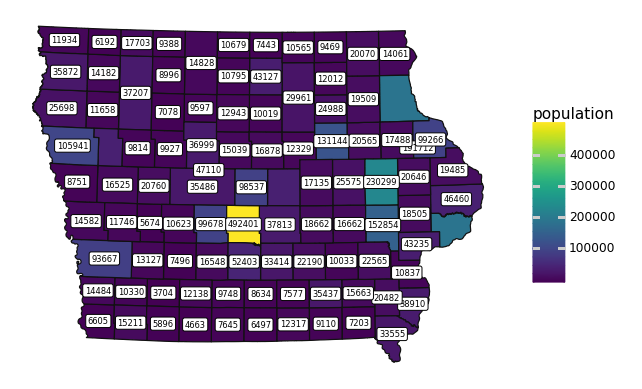

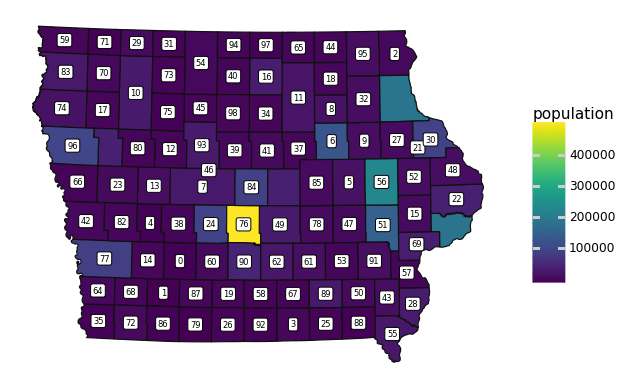

(<ggplot: (8790901713228)>, <ggplot: (8790901689236)>)

In [81]:
map_merged_districts(shapef_ia_running)

In [82]:
len(shapef_ia_running)

94

# Leftover maps and visualization tools from Iowa_redistricting (ignore until above stuff is working)

## District size bounds

In [10]:
ideal_district_size=state_population/n_districts
tolerance=.01
district_maximum=int(ideal_district_size*(1+tolerance))
district_minimum=int(ideal_district_size*(1-tolerance))

## Visualizing the districts

### Prepping the data for visualization

In [16]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'county_id': i,
            'district': j+1,
            'assignment': int(assignment[i][j].value()*(j+1)),
            'allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['assignment'] != 0]
results = results.sort_values(['county_id', 'district'])
results


,county_id,district,assignment,allocation
2,0,3,3,7496
7,1,4,4,3704
9,2,2,2,14061
14,3,3,3,12317
16,4,1,1,5674
...,...,...,...,...
379,94,4,4,10679
381,95,2,2,20070
384,96,1,1,105941
391,97,4,4,7443


In [17]:
results = results.merge(census_df, on='county_id')
results

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
0,0,3,3,7496,Adair,7496,001,41.328528,-94.478164
1,1,4,4,3704,Adams,3704,003,41.021656,-94.696906
2,2,2,2,14061,Allamakee,14061,005,43.274964,-91.382751
3,3,3,3,12317,Appanoose,12317,007,40.744683,-92.870345
4,4,1,1,5674,Audubon,5674,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...,...
96,94,4,4,10679,Winnebago,10679,189,43.378124,-93.743488
97,95,2,2,20070,Winneshiek,20070,191,43.292989,-91.850788
98,96,1,1,105941,Woodbury,105941,193,42.393220,-96.053296
99,97,4,4,7443,Worth,7443,195,43.373491,-93.248533


In [18]:
results.loc[(results['allocation'])!=(results['population'])]

,county_id,district,assignment,allocation,county,population,COUNTYFP10,latitude,longitude
51,51,2,2,30571,Johnson,152854,103,41.668737,-91.588812
52,51,3,3,122283,Johnson,152854,103,41.668737,-91.588812
77,76,1,1,393920,Polk,492401,153,41.684281,-93.569720
78,76,3,3,98481,Polk,492401,153,41.684281,-93.569720


In [ ]:
# results_test=results.copy()

In [ ]:
# results_test['multiple_county_name'] = results_test['county'].shift(periods=1)
# results_test['multiple_district'] = results_test['district'].shift(periods=1).fillna(99).astype(int)


In [ ]:
# results_test

In [ ]:
# Edit the assignment for the case when a county has multiple assignments 
# for i in range(0,len(results_test)):
#     if results_test['county'].loc[i] == results_test['multiple_county_name'].loc[i]:
#         results_test.loc[i, 'assignment'] =   int(str(results_test['district'].loc[i]) + \
#                                                         str(results_test['multiple_district'].loc[i]))
# results_test = results_test.sort_values(['district','county'])
# results_test.index = results_test['county_id']

In [ ]:
# results_test.loc[results_test['county_id']==76]

## Creating the maps

In [19]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [24]:
shapefile_and_assignments = shapefile_iowa.merge(results, on='COUNTYFP10')
# map_first_pass['District'] = map_first_pass['District']+1
shapefile_and_assignments.head()


,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,CD,geometry,county_id,district,assignment,allocation,county,population,latitude,longitude
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157...",0,3,3,7496,Adair,7496,41.328528,-94.478164
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158...",1,4,4,3704,Adams,3704,41.021656,-94.696906
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500...",2,2,2,14061,Allamakee,14061,43.274964,-91.382751
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812...",3,3,3,12317,Appanoose,12317,40.744683,-92.870345
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688...",4,1,1,5674,Audubon,5674,41.679178,-94.904312


In [25]:
# map_first_pass['District'] = map_first_pass['District'].astype('category')
shapefile_and_assignments['assignment'] = shapefile_and_assignments['assignment'].astype("category")

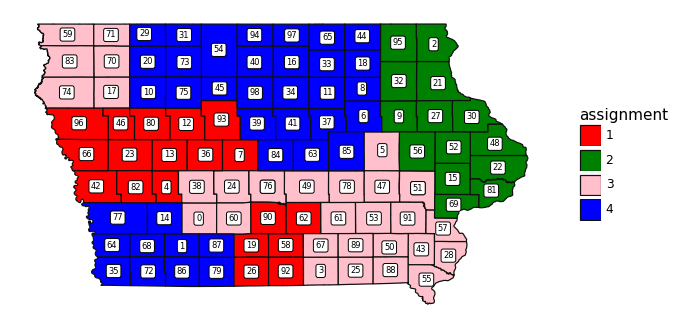

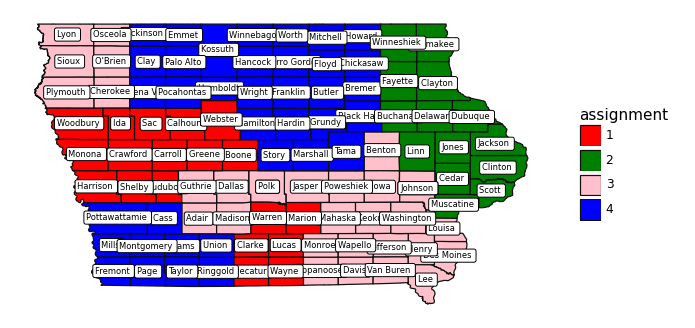

(<ggplot: (399377418)>, <ggplot: (399394624)>)

In [26]:
iowa_map(shapefile_and_assignments)

In [23]:
district_totals = pd.DataFrame(results.groupby('district')['allocation'].sum().astype('int64'))
district_totals

,allocation
district,
1,795471
2,791872
3,805236
4,797790
